In [ ]:
# !pip install pycaret[full]
# !pip install seaborn
# !pip install holidays
# !pip install geopy

In [2]:
# import
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import geopy.distance as distance
from pycaret.regression import *
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, Normalizer, OneHotEncoder
import holidays as holidays

In [3]:
# coord_df = pd.read_csv('coordinate.csv', encoding='utf-8')
# coord_df['latitude'] = coord_df['latitude'].round(2)
# coord_df['longitude'] = coord_df['longitude'].round(1)

# 라벨 인코더
le = LabelEncoder()
# 원-핫 인코더
ohe = OneHotEncoder(sparse_output=False)
# 스케일러
scaler = StandardScaler()
# 정규화
normalizer = Normalizer()

In [4]:
def trans_data(df):
    # 날짜
    df['date'] = pd.to_datetime(df['date'])
    ## 날짜2
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday

    # 주말
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x in [5, 6] else 0)

    # 공휴일 여부
    kr_holidays = holidays.KR(years=2019)
    df['is_holiday'] = df['date'].isin(kr_holidays.keys())

    # 시간별 승하차 인원
    df['6~8_ride'] = df[['6~7_ride','7~8_ride']].sum(1)
    df['8~10_ride'] = df[['8~9_ride','9~10_ride']].sum(1)
    df['10~12_ride'] = df[['10~11_ride','11~12_takeoff']].sum(1)
    df['6~8_takeoff'] = df[['6~7_takeoff','7~8_takeoff']].sum(1)
    df['8~10_takeoff'] = df[['8~9_takeoff','9~10_takeoff']].sum(1)
    df['10~12_takeoff'] = df[['10~11_takeoff','11~12_takeoff']].sum(1)

    # 거리 계산
    north_coord = (33.524807, 126.513258)     # 제주시
    south_coord = (33.266964, 126.563705)   # 서귀포시
    east_coord = (33.515892, 126.883168)
    west_coord = (33.3341191, 126.1815651)
    df['north_distance'] = df.apply(lambda row: distance.distance(north_coord, (row['latitude'], row['longitude'])).km, axis=1)
    df['south_distance'] = df.apply(lambda row: distance.distance(south_coord, (row['latitude'], row['longitude'])).km, axis=1)
    df['east_distance'] = df.apply(lambda row: distance.distance(east_coord, (row['latitude'], row['longitude'])).km, axis=1)
    df['west_distance'] = df.apply(lambda row: distance.distance(west_coord, (row['latitude'], row['longitude'])).km, axis=1)


    # 지역
    df['lat_lon1'] = df['latitude'].round(2).astype(str)+df['longitude'].round(2).astype(str)
    df['lat_lon2'] = df['latitude'].round(3).astype(str)+df['longitude'].round(3).astype(str)
    df['lat_lon1'] = le.fit_transform(df['lat_lon1'])
    df['lat_lon2'] = le.fit_transform(df['lat_lon2'])

    # 시외, 시내
    df['in_out'] = df['in_out'].apply(lambda x: 1 if x == '시외' else 0)

    # 원 핫 인코딩
    one_features = ['weekday']
    encoded = ohe.fit_transform(df[one_features])
    encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(one_features))
    df = pd.concat([df.drop(columns=one_features), encoded_df], axis=1)

    # 필요 없는 값 삭제
    df.drop(columns=['id', 'station_name', 'date'], inplace=True, axis=1)
    df.drop(columns=['6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride',
                     '6~7_takeoff', '7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
                     'latitude', 'longitude'],
            inplace=True, axis=1)

    return df

In [5]:
pd.set_option('display.max_columns', None)
# 1. 데이터
train_df =  pd.read_csv('train.csv', encoding='utf-8')
test_df =  pd.read_csv('test.csv', encoding='utf-8')

train_df = trans_data(train_df)
test_df = trans_data(test_df)

train_df.head()
# test_df.head()

,bus_route_id,in_out,station_code,18~20_ride,day,is_weekend,is_holiday,6~8_ride,8~10_ride,10~12_ride,6~8_takeoff,8~10_takeoff,10~12_takeoff,north_distance,south_distance,east_distance,west_distance,lat_lon1,lat_lon2,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,4270000,1,344,0.0,1,1,False,1.0,7.0,2.0,0.0,0.0,0.0,4.275736,25.569071,36.300996,33.788193,600,1981,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,4270000,1,357,5.0,1,1,False,5.0,6.0,5.0,0.0,0.0,0.0,4.716158,25.736880,37.106360,33.072772,600,1943,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,4270000,1,432,2.0,1,1,False,2.0,2.0,0.0,0.0,0.0,0.0,6.031316,25.263471,38.253245,31.715518,570,1845,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4270000,0,1579,53.0,1,1,False,17.0,32.0,14.0,0.0,0.0,0.0,2.858392,27.301870,36.312822,34.624985,626,2185,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4270000,0,1646,0.0,1,1,False,0.0,0.0,0.0,0.0,1.0,0.0,31.272292,14.133900,52.433028,23.206282,86,341,0.0,0.0,0.0,0.0,0.0,0.0,1.0


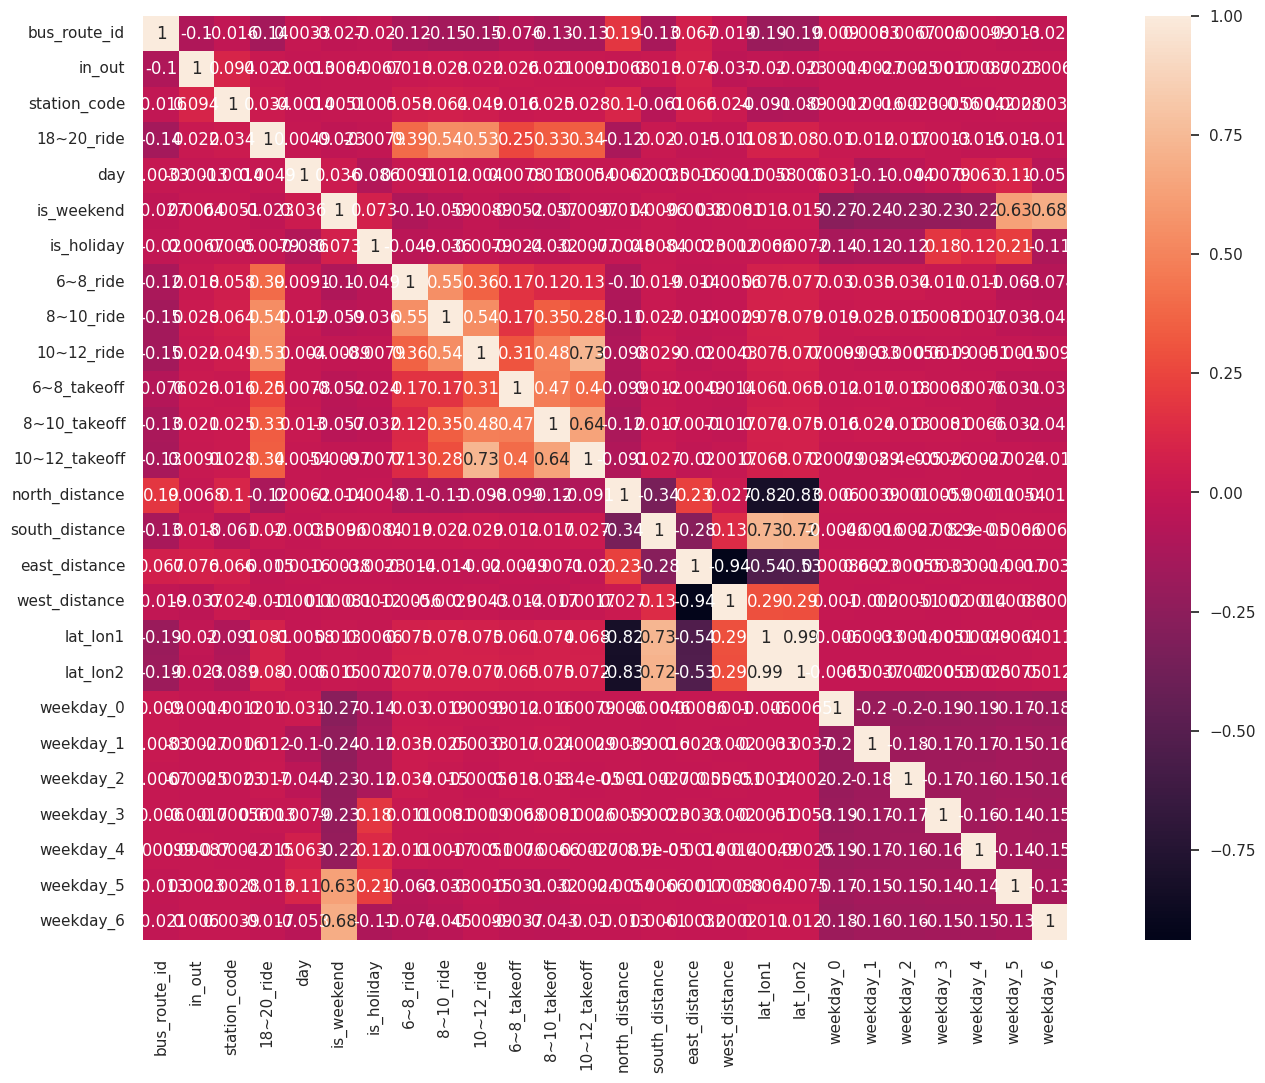

In [6]:
# 시각화
## 히트맵
sns.set(rc={'figure.figsize':(20, 12)})
sns.heatmap(data=train_df.corr(), square=True, annot=True, cbar=True)
plt.show()

In [7]:
# 2. setup
s = setup(
    session_id=123,
    data = train_df,
    target = '18~20_ride',
    train_size=0.8,
    categorical_features=['bus_route_id', 'station_code', 'in_out', 'is_holiday', 'is_weekend'],
    verbose=True,
    # use_gpu=True
)

,Description,Value
0,Session id,123
1,Target,18~20_ride
2,Target type,Regression
3,Original data shape,"(415423, 26)"
4,Transformed data shape,"(415423, 26)"
5,Transformed train set shape,"(332338, 26)"
6,Transformed test set shape,"(83085, 26)"
7,Numeric features,20
8,Categorical features,5
9,Preprocess,True


In [8]:
# get_config('X_train')
get_config('X_train_transformed')

,bus_route_id,in_out,station_code,day,is_weekend,is_holiday,6~8_ride,8~10_ride,10~12_ride,6~8_takeoff,8~10_takeoff,10~12_takeoff,north_distance,south_distance,east_distance,west_distance,lat_lon1,lat_lon2,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
276567,32320000,0.0,49,20.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,8.854345,27.152306,42.181015,28.580015,566.0,1884.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
310419,32580000,0.0,60,23.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,8.434774,27.905434,42.092010,29.109203,594.0,2010.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
168873,22550000,0.0,6103001,13.0,0.0,1.0,7.0,13.0,4.0,0.0,0.0,1.0,30.539944,5.486903,45.690960,31.876862,61.0,205.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
368871,29110000,0.0,472,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,17.658731,22.636568,47.768089,20.664274,375.0,1208.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
71010,31880000,0.0,553,5.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,11.238317,23.316011,42.322029,26.735304,473.0,1423.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192476,27250000,0.0,4194,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,38.316727,38.307861,8.192113,69.372543,490.0,1435.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17730,26040000,0.0,1957,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,30.482779,1.592223,41.857700,36.434921,66.0,302.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28030,22530000,0.0,3271,3.0,0.0,0.0,2.0,3.0,21.0,22.0,27.0,53.0,3.281112,25.913069,32.835941,37.235985,659.0,2109.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
277869,21480000,0.0,358,21.0,1.0,0.0,0.0,2.0,2.0,0.0,4.0,1.0,4.651554,25.732897,37.019440,33.156784,600.0,1977.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
# 가장 좋은 모델 찾기
model = compare_models(sort='MAE')
# top3 = compare_models(sort='MAE', n_select=3)

# 특정 모델 선택
# model = create_model('rf')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,0.8728,7.7730,2.7869,0.6551,0.4674,0.6982,61.9040
rf,Random Forest Regressor,0.9941,8.1125,2.8437,0.6418,0.5101,0.7010,415.0490
catboost,CatBoost Regressor,1.0326,7.4763,2.7318,0.6689,0.5201,0.6622,62.5560
xgboost,Extreme Gradient Boosting,1.0369,8.0051,2.8251,0.6459,0.5215,0.6778,7.1920
lightgbm,Light Gradient Boosting Machine,1.0841,8.1758,2.8569,0.6379,0.5388,0.6824,11.1700
et,Extra Trees Regressor,1.0890,9.0914,3.0100,0.5987,0.5517,0.7633,265.7420
gbr,Gradient Boosting Regressor,1.1785,10.8819,3.2937,0.5197,0.5763,0.7154,87.2910
dt,Decision Tree Regressor,1.2439,16.4797,4.0564,0.2694,0.6438,1.0567,9.3000
en,Elastic Net,1.2976,13.9504,3.7284,0.3851,0.6199,0.7780,12.7940
llar,Lasso Least Angle Regression,1.3016,14.1507,3.7553,0.3762,0.6217,0.7573,3.9770


Processing:   0%|          | 0/87 [00:00<?, ?it/s]

In [ ]:
# ensemble
# tuned_top3 = [tune_model(i, optimize='MAE', search_library = 'optuna') for i in top3]
# best = blend_models(top3, optimize='MAE')
# stack_lr = stack_models(best, optimize='MAE', choose_better=True)
# model = finalize_model(stack_lr)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:25:27
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Voting Regressor


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# # 그래프
# evaluate_model(model)
# plot_model(model, plot = 'residuals')
# plot_model(model, plot = 'feature')
# interpret_model(model, plot='summary', observation=100)  # 100개 샘플만 SHAP 계산

In [ ]:
# 예측점수
predict_model(model)

# 예측하기
predictions = predict_model(model, data=test_df)
predictions

In [ ]:
# 예측값을 반올림하여 정수로 변환
predictions['prediction_label'] = predictions['prediction_label'].round()
predictions['prediction_label'] = predictions['prediction_label'].astype(int)

# 컬럼 이름 변경
predictions = predictions.rename(columns={'prediction_label': '18~20_ride'})

In [ ]:
# submission_sample.csv 읽기
submission_sample = pd.read_csv('submission_sample.csv')

# 예측값 '18~20_takeoff' 컬럼을 submission_sample에 합치기
submission_sample['18~20_ride'] = predictions['18~20_ride']

# 결과를 새로운 CSV로 저장
submission_sample.to_csv('submission.csv', index=False)

# 결과 확인
print(submission_sample.head())